In [1]:
from pathlib import Path

import spacy
from spacy.tokens import Doc
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from itertools import chain

import numpy as np

from thesis.plotting_utils import get_figsize, thesis_figure_style

In [2]:
DATA_DIR = Path("../data/")
FIGURE_DIR = Path("../figures")

nlp = spacy.load("en_core_web_sm")

## Load Data 

In [3]:
human_reviews = (
    pd.read_csv(DATA_DIR / "human" / "review_data_preprocessed.csv", index_col="id")
    .loc[lambda df: df.set_label == "classification"]
    .rename(columns={"review_title": "title", "review_text": "text"})
)
llm_reviews = pd.read_json(
    DATA_DIR / "generated" / "reviews.jsonl", orient="records", lines=True
).set_index(["review_id", "strategy"])
hf_reviews = llm_reviews.loc[lambda df: df.source == "hf"]
openai_reviews = llm_reviews.loc[lambda df: df.source == "openai"]

## Sample reviews

In [4]:
SEED = 42


def pretty_print_reviews(reviews: pd.DataFrame):
    for i, row in reviews.iterrows():
        print("----------------------------------------------")
        print(f"Index: {i}")
        print(f"Title: {row.title}")
        print(f"Text: {row.text}")
        print()

In [5]:
hf_reviews.sample(50, random_state=SEED).pipe(pretty_print_reviews)

----------------------------------------------
Index: (1374, 'fake')
Title: Disappointing Moto E6
Text: Underwhelming experience with too many bugs and glitches. Not recommended.

----------------------------------------------
Index: (1500, 'crowdworkers')
Title: Samsung Galaxy J2 Core - 1 star
Text: Poor performance, laggy and hangs often.

----------------------------------------------
Index: (1371, 'few_shot_deceptive')
Title: OnePlus 6 Review
Text: The OnePlus 6 is a really bad phone. The camera is bad and the battery life is short.

----------------------------------------------
Index: (1625, 'persona_old')
Title: Disappointed with Samsung Galaxy S9
Text: Upset with performance and glitchy software.

----------------------------------------------
Index: (1988, 'persona_young')
Title: Amazing Value for Money!
Text: The Pixel 3a exceeded all my expectations. The camera quality is top-notch and the battery life is impressive. Highly recommend for anyone looking for a reliable and aff

In [6]:
openai_reviews.sample(50, random_state=SEED).pipe(pretty_print_reviews)

----------------------------------------------
Index: (1924, 'few_shot_deceptive')
Title: Outstanding Budget Phone!
Text: Exceeded expectations for the price. Great display, battery life, and overall performance. Highly recommend the A10!

----------------------------------------------
Index: (979, 'crowdworkers')
Title: Samsung Galaxy A50: A Solid Mid-Ranger
Text: The Galaxy A50 offers a vibrant Super AMOLED display and a versatile camera setup. Decent battery life and smooth performance make it a good choice for daily use. Some software bloat, but overall, a commendable device.

----------------------------------------------
Index: (1151, 'persona_old')
Title: Reliable and User-Friendly
Text: The Xiaomi Mi A1 delivers smooth performance and great value for its price.

----------------------------------------------
Index: (1557, 'fake')
Title: Disappointing Performance and Battery Issues
Text: I had high hopes for the Oppo A5s given its appealing design and budget-friendly price point

## Compare length distribution

In [7]:
def get_length(text: Doc) -> int:
    words = [token for token in text if not token.is_punct and not token.is_space]
    return len(words)

In [8]:
human_docs = list(nlp.pipe(human_reviews.text))
hf_docs = list(nlp.pipe(hf_reviews.text))
openai_docs = list(nlp.pipe(openai_reviews.text))

In [9]:
human_lengths = [get_length(doc) for doc in human_docs]
hf_lengths = [get_length(doc) for doc in hf_docs]
openai_lengths = [get_length(doc) for doc in openai_docs]

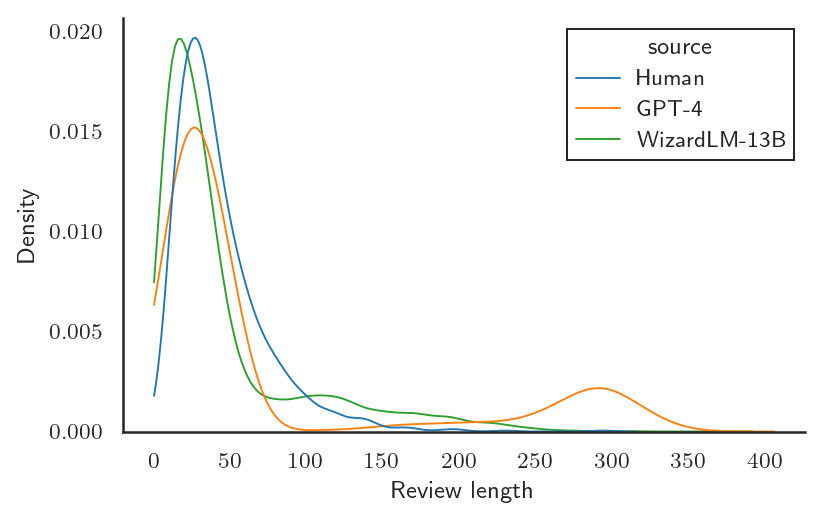

In [10]:
# plot length distributions
def plot_review_length_distribution():
    length_dfs = list()
    for name, values in zip(
        ["Human", "GPT-4", "WizardLM-13B"], [human_lengths, openai_lengths, hf_lengths]
    ):
        df = pd.DataFrame({"length": values}).assign(source=name)
        length_dfs.append(df)
    lengths = pd.concat(length_dfs, ignore_index=True)

    with thesis_figure_style(sns_style_args={"style": "white"}):
        fig = plt.figure(figsize=get_figsize(fraction=0.8))
        ax = fig.gca()

        sns.kdeplot(
            lengths, x="length", hue="source", ax=ax, common_norm=False, clip=(0, None)
        )

        sns.despine(ax=ax)
        ax.set_xlabel("Review length")
        fig_path = FIGURE_DIR / "review_length_distribution.pgf"
        fig.savefig(fig_path, backend="pgf")


plot_review_length_distribution()

### Compare frequencies

In [11]:
def get_lemmatized(text: Doc) -> list[str]:
    return [
        token.lemma_
        for token in text
        if not token.is_punct and not token.is_space and not token.is_stop
    ]


def get_token_frequencies(texts: list[Doc]) -> dict[str, float]:
    texts_lemmatized = [get_lemmatized(t) for t in texts]
    tokens = list(chain(*texts_lemmatized))
    counts = Counter(tokens)
    n_tokens = sum(counts.values())
    frequencies = {t: c / n_tokens for t, c in counts.items()}

    return frequencies

In [14]:
def get_term_frequency_difference(
    corpus_1: list[list[str]], corpus_2: list[list[str]]
) -> pd.DataFrame:

    corpus_1_freq = defaultdict(lambda: 0) | get_token_frequencies(corpus_1)
    corpus_2_freq = defaultdict(lambda: 0) | get_token_frequencies(corpus_2)

    diff = {
        k: corpus_1_freq[k] - corpus_2_freq[k]
        for k in set(corpus_1_freq.keys()) | set(corpus_2_freq.keys())
    }
    diff = pd.DataFrame(
        {"term": list(diff.keys()), "difference": list(diff.values())}
    ).sort_values("difference", ascending=False, key=np.abs)

    return diff


def compare_term_frequencies(corpus_1: list[Doc], corpus_2: list[Doc], top_n: int = 10):

    freq_diff = get_term_frequency_difference(corpus_1, corpus_2)

    fig, ax = plt.subplots(figsize=(5, 5))
    sns.barplot(
        x="difference",
        y="term",
        data=freq_diff.head(top_n),
        ax=ax,
    )
    plt.show()

In [15]:
compare_term_frequencies(human_docs, openai_docs, 20)

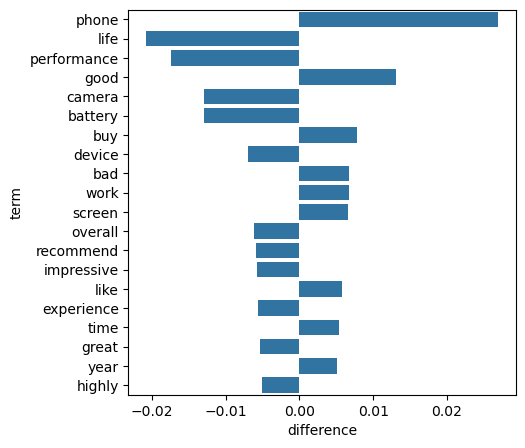

In [16]:
compare_term_frequencies(human_docs, hf_docs, 20)

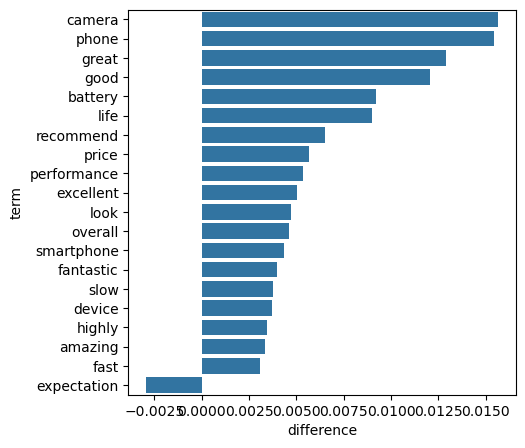

In [17]:
compare_term_frequencies(hf_docs, openai_docs, 20)